# AlgebraNet - Learning Algebra from Scratch

*This notebook first appeared as a [blog post](//betatim.github.io/posts/algebra-from-scratch) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

In this post a computer will learn basic algebra, from scratch! Not excited? Keep reading. This is an introduction to basic sequence-to-sequence learning using a [Long short term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) module.

Sequences of varying length are everywhere around us. Yet most machine-learning problems
are presented as "here are five features describing each instance, please predict these three
properties". Or some variation on this. This is not a particularly good fit with
sequences of varying length like: sentences, sound recordings, or time series data. In
addition the order in which things occur in the sequence carries meaning. Let's take
advantage of all that structure!

Imagine trying to shoehorn the task of translating English sentences to German sentences into
a classical $N$ features and $M$ outputs setup. A bit of a nightmare. This is where
sequence to sequence learning comes in. You feed in a sequence and produce a new sequence,
potentially of different length.

You can use this for translating English to German, generating captions for images, or
as we will do: learn how to do basic algebra.


## The Problem

Given a string of characters representing a math problem `"3141+42"` we would like
to generate a string of characters representing the correct solution: `"3183"`. Our
network will learn how to do addition, subtraction, multiplication and division.

The important
part is that we will not first use our human intelligence to break the string up into
integers and a mathematical operator. We want the computer to figure all that out by
itself.

Let's go! This post will use the excellent [`keras`](https://keras.io/) deep-learning
library and is based on one of their [examples](https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py).

First some imports, and then we generate examples.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import operator

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

from keras.models import Sequential
from keras.layers import Dense, RepeatVector, TimeDistributed, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import SGD

Using Theano backend.


In [3]:
OPS = ['+', '*', '-', '/']
ABC = '1234567890' + ''.join(OPS) + '. '

## Creating Examples

Using simple algebra problems like this demonstrates all the basics of
sequence to sequence learning and allows us to generate a lot of data
very quickly (compared to say audio recordings).

We need a way to represent a sequence of characters as a sequence of
binary vectors, this is what `encode` and `decode` take care of. Each
character is [one-hot encoded](https://en.wikipedia.org/wiki/One-hot). The
`make_maths_problem` function uses them to generate a large set of
examples.

In [12]:
def encode(characters):
    """Encode a string as an array of integers."""
    char_idx = dict((c, i) for i, c in enumerate(ABC))
    X_ = np.zeros((len(characters), len(ABC)))
    for i, c in enumerate(characters):
        try:
            X_[i, char_idx[c]] = 1
        except:
            print('chars:', characters)
            print(i, c, char_idx[c], X_.shape)
    return X_


def decode(X, calc_argmax=True):
    """Decode an array of integers to a string."""
    idx_char = dict((i, c) for i, c in enumerate(ABC))
    X = X.argmax(axis=-1)    
    return ''.join(idx_char[i] for i in X)


# Generate data
def make_maths_problem(n_samples=1000, n_digits=3, invert=True, random_state=None):
    rng = check_random_state(random_state)
    
    X_ = []
    y_ = []
    
    assert all(op in ABC for op in OPS), "Not all operations are in the alphabet"
    
    math_op = {'+': operator.add, 
               '-': operator.sub,
               '*': operator.mul,
               '/': operator.truediv}
    n_ops = len(OPS)
    # the one represents the character for the operator
    max_len = 2 * n_digits + 1

    while len(X_) < n_samples:
        a, b = rng.randint(10**n_digits, size=2)
        op = rng.choice(OPS)
        a_op_b = "%i%s%i" % (a, op, b)
        if a_op_b not in X_:
            answer = math_op[op](a, b)

            if answer == np.inf or np.isnan(answer):
                continue
            
            if invert:
                X_.append(a_op_b.ljust(max_len)[::-1])
            else:
                X_.append(a_op_b.ljust(max_len))
            # make sure the string is white space padded but no longer
            # than the max length (could happen when representing 1/3)
            y_.append(str(answer).ljust(2 * n_digits)[:2 * n_digits])
    
    X = np.zeros((n_samples, max_len, len(ABC)),
                 dtype=np.bool)
    y = np.zeros((n_samples, 2 * n_digits, len(ABC)),
                 dtype=np.bool)
    for i, x in enumerate(X_):
        X[i] = encode(x)
        
    for i, x in enumerate(y_):
        y[i] = encode(x)

    return (X, y)

## Encoding

An algebra problem like `"23+42"` would be encoded as a sequence of five
arrays, one each for each character.

In [5]:
encode("23+42")

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]])

Let's try out our math problem generator and check that we can correctly
round trip problems:

In [14]:
X, y = make_maths_problem(10, n_digits=3)

for i in range(10):
    # undo question reversal
    q = decode(X[i][::-1])
    correct = decode(y[i])
    print(q, '=', correct)

646/541 = 1.1940
31*70   = 2170  
12+757  = 769   
96*516  = 49536 
291/612 = 0.4754
22+941  = 963   
188*632 = 118816
370/824 = 0.4490
794*918 = 728892
136/201 = 0.6766


Looks like it works.


## Big Data

To learn the model we need more than ten examples, so we make a big set of
problems and simultaneously set some of them aside as test data set that
we can use to evaluate the performance of the model.

In [17]:
X, y = make_maths_problem(2*50000, n_digits=3, random_state=234)
X_train,X_test, y_train,y_test = train_test_split(X, y, train_size=0.8)

## The Model

We use a single LSTM to encode the input sequence into a fixed length
state vector. This vector is then decoded by a second LSTM to produce
the output sequence. The final layer is a softmax layer to pick which
character to place at each position of the output sequence.

In [18]:
def rnn_model(hidden_size=128, n_digits=3, abc_size=len(ABC)):
    model = Sequential()
    # encoder
    model.add(LSTM(hidden_size, input_shape=(None, abc_size)))
    # input for the decoder
    # this sets the length of the output sequence and has to
    # match the length we used when constructing the examples
    model.add(RepeatVector(2 * n_digits))

    # decoder model
    model.add((LSTM(hidden_size, return_sequences=True)))

    # For each step of the output sequence, decide which character should be chosen
    model.add(TimeDistributed(Dense(abc_size)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

## Training

Let's train the model for a few epochs and see how it performs afterwards. Every ten epochs
we will print out ten test math problems for manual inspection. By reusing the same ten
examples we can see if the network is making progress or not.

In [22]:
BATCH_SIZE = 128

model = rnn_model()

# use same 10 examples for all iterations
n_test = 10
idx = np.random.randint(len(X_test), size=n_test)
Xs, ys = X_test[idx], y_test[idx]

for iteration in range(3):
    print()
    print('-' * 50)
    print('After', 10 * (iteration + 1), 'epochs:')
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=10, verbose=False,
              validation_data=(X_test, y_test))

    probas = model.predict_proba(Xs, verbose=0)

    for i in range(n_test):
        # undo question reversal
        q = decode(Xs[i][::-1])
        correct = decode(ys[i])
        guess = decode(probas[i])
        print(q, '=', correct, '=?', guess)


--------------------------------------------------
After 10 epochs:
586/75  = 7.8133 =? 7.9211
943-826 = 117    =? 135   
249/532 = 0.4680 =? 0.4999
241-660 = -419   =? -493  
368*178 = 65504  =? 63392 
110-948 = -838   =? -866  
7/277   = 0.0252 =? 0.0192
522/956 = 0.5460 =? 0.5959
61*454  = 27694  =? 29992 
260*994 = 258440 =? 289960
78*459  = 35802  =? 39992 
79+450  = 529    =? 633   
764+190 = 954    =? 992   
335*477 = 159795 =? 163925
887*263 = 233281 =? 219999
183-864 = -681   =? -695  
53-116  = -63    =? -15   
453+214 = 667    =? 673   
837+392 = 1229   =? 1235  
924/134 = 6.8955 =? 5.5522

--------------------------------------------------
After 20 epochs:
586/75  = 7.8133 =? 7.28  
943-826 = 117    =? 111   
249/532 = 0.4680 =? 0.4414
241-660 = -419   =? -413  
368*178 = 65504  =? 66444 
110-948 = -838   =? -812  
7/277   = 0.0252 =? 0.0211
522/956 = 0.5460 =? 0.5410
61*454  = 27694  =? 24444 
260*994 = 258440 =? 251460
78*459  = 35802  =? 34444 
79+450  = 529    =? 535  

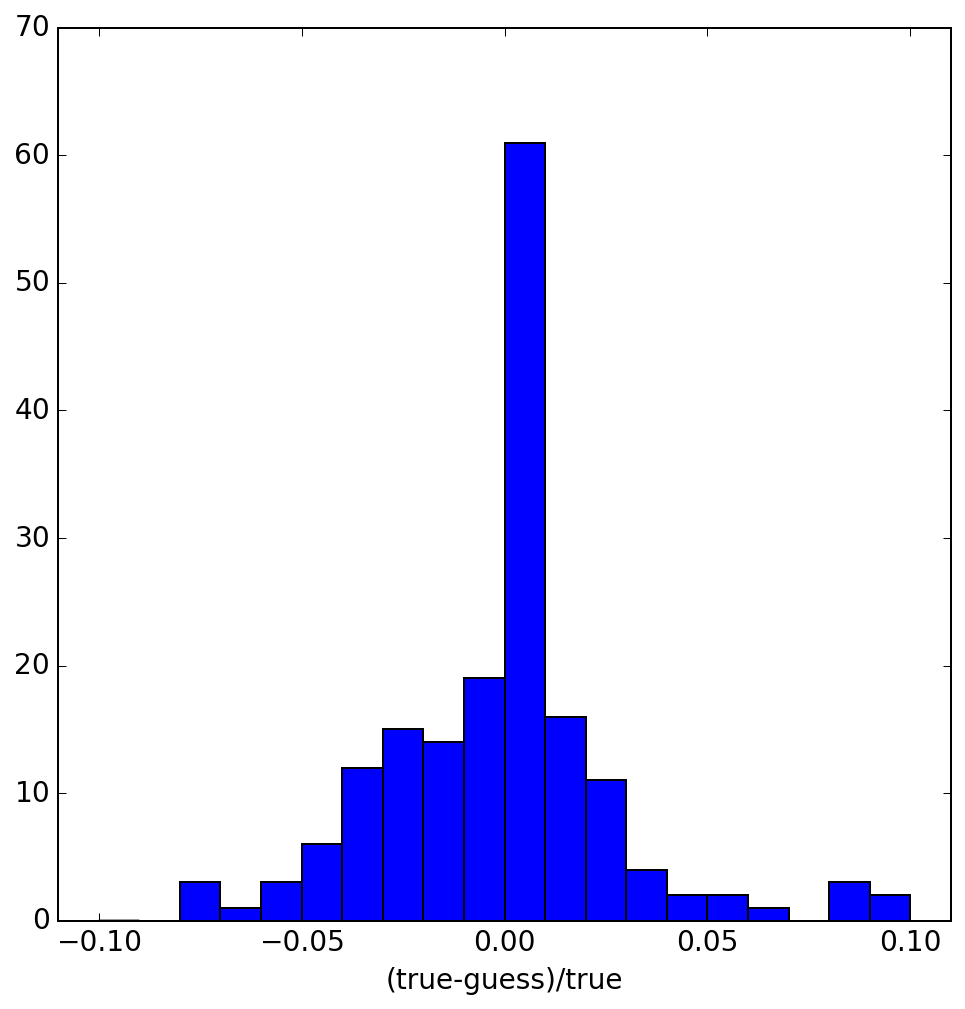

In [24]:
def fractional_difference(n_test=200):
    idx = np.random.randint(len(X_test), size=n_test)
    Xs, ys = X_test[idx], y_test[idx]
    probas = model.predict_proba(Xs, verbose=0)
    true_ = np.array([float(decode(ys[i])) for i in range(n_test)])
    predicted_ = np.array([float(decode(probas[i])) for i in range(n_test)])

    _ = plt.hist((true_ - predicted_)/true_, range=(-0.1, 0.1), bins=20)
    plt.xlabel('(true-guess)/true')
    plt.xlim(-0.11, 0.11)
    
fractional_difference()

It looks as if after such a short amount of training we get within roughly 5% of the right
answer, and frequently even closer. From monitoring the loss on an evaluation set I think
this network would continue to improve if trained for a larger number of epochs.


## Conclusion

While the network does not perform perfectly yet, this illustrates how to build a network
that performs sequence-to-sequence learning. Without any knowledge about algebra or even
digits it learnt to do reasonably well on basic math problems. It even figured out how to
use the decimal point!

Some next steps could be:

* generating words instead of numbers, the network would output `"thirtytwo"`
  instead of `"32"`;
* using images of digits as input instead of strings;
* using voice as input or output; or
* solving a completely different problem based around sequences.

Get in touch on twitter @[betatim](//twitter.com/betatim) if you have questions or comments.